## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

In [1]:
!pip install unidecode
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importación librerías
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Carga de la base de datos

In [3]:
dt= pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0).reset_index().drop("index",axis=1)

# Visualización de la base de datos

In [4]:
dt.head()

,year,title,plot,genres,rating
0,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
1,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
2,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
3,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
4,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


## Tamaño de la  base de datos

In [5]:
dt.shape

(7895, 5)

Se descartan las variables que no aportan al proyecto

In [6]:
dt=dt[["plot","genres"]]
dt.head()

,plot,genres
0,most is the story of a single father who takes...,"['Short', 'Drama']"
1,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']"
2,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']"
3,"in a friday afternoon in new york , the presi...",['Drama']
4,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']"


# Tipos de variables

In [7]:
dt.dtypes

plot      object
genres    object
dtype: object

# Peso de la base de datos

In [8]:
import sys
print("La base de datos tiene un peso de ",sys.getsizeof(dt)," bytes")

La base de datos tiene un peso de  7045029  bytes


# Cantidad de filas vacias en la base de datos

In [9]:
dt.isnull().sum()

plot      0
genres    0
dtype: int64

## Preprocesamiento

In [10]:
def preprocess(text,min_len=2, max_len=23):
    pat = re.compile(r"[^a-z ]")
    spaces = re.compile(r"\s{2,}")

    # Normalizamos el texto
    norm_text = unidecode(text)
    doc = nlp(norm_text)

    # Eliminamos stopwords
    filtered_tokens = filter(lambda token: not token.is_stop, doc )

    # Filtramos palabras por longitud
    filtered_tokens2 = filter(lambda token: len(token) >= min_len
                              and len(token) <= max_len, filtered_tokens)

    # Obtenemos los lemmas de cada token
    lemmas = map(lambda token: token.lemma_, filtered_tokens2 )
    stem = map( lambda token: snow_stemmer.stem(token), lemmas )
    lemma_text = " ".join(stem)

    # Quitamos grafía
    lower_text = lemma_text.lower()

    # Eliminamos caracteres especiales
    clean_text = re.sub(pat, "", lower_text)

    # Eliminamos espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)
    return spaces_text.strip()
prepo_text=list(nlp.pipe(dt["plot"].apply(preprocess).tolist(), n_process=-1))

In [11]:
dt['preprocessed_plot'] = [doc.text for doc in prepo_text]

#  Preprocesamiento Variable objetivo

In [12]:
dt["genres"] = dt["genres"].apply(lambda x: x.replace('[','').replace(']','').replace("\'",''))
dt.head()

,plot,genres,preprocessed_plot
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...


In [13]:
genres_df = dt['genres'].str.get_dummies(sep=', ')
data = dt.drop(['genres','preprocessed_plot'], axis=1)
data = pd.concat([dt, genres_df], axis=1)
data.head()

,plot,genres,preprocessed_plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Embedding de la variable plot con limpieza de tokens

In [14]:
vect = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=0.03).fit(dt.preprocessed_plot)
display(vect)

features = vect.transform(dt.preprocessed_plot).toarray()
display(features.shape)


TfidfVectorizer(max_df=0.95, min_df=0.03, sublinear_tf=True)

(7895, 280)

In [15]:
emb=[]
target=[]
for i in range(data.shape[0]):
  for j in data.genres[i].split(', '):
    if j!="News":
      emb.append(features[i])
      target.append(j)
emb=np.array(emb)
target=np.array(target)
print(emb.shape,target.shape)

(21569, 280) (21569,)


In [16]:
target=pd.get_dummies(target)
gen=target.columns
target=target.to_numpy()

In [17]:
X_train, X_test, y_train, y_test = train_test_split( emb, target, test_size=0.15, random_state=42,stratify=target)

In [18]:
X_Train, X_val, y_Train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42,stratify=y_train)

In [19]:
print(y_Train.shape,y_val.shape,y_test.shape)

(15583, 23) (2750, 23) (3236, 23)


In [20]:
print(X_Train.shape,X_val.shape,X_test.shape)

(15583, 280) (2750, 280) (3236, 280)


In [21]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 8.1 MB/s eta 0:00:00


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from keras_tuner import HyperModel, RandomSearch
import keras_tuner

In [23]:
batch_size=X_Train.shape[0]//32
train_dataset =tf.data.Dataset.from_tensor_slices((X_Train, y_Train)).shuffle(len(X_Train))
train_dataset = train_dataset.shuffle(len(X_Train)).batch(batch_size, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [141]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=64, max_value=512, step=32),activation='relu', input_shape=(None,X_Train.shape[1])))
    model.add(Dense(units=hp.Int('units2', min_value=64, max_value=256, step=32),activation='relu'))
    model.add(Dense(23, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [142]:
nn = build_model(keras_tuner.HyperParameters())
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, None, 64)          17984     
                                                                 
 dense_4 (Dense)             (None, None, 64)          4160      
                                                                 
 dense_5 (Dense)             (None, None, 23)          1495      
                                                                 
Total params: 23,639
Trainable params: 23,639
Non-trainable params: 0
_________________________________________________________________


In [143]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="",
    project_name="movie",
)

In [144]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [145]:
tuner.search(train_dataset, epochs=30,validation_data=val_dataset,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode="max")])

Trial 3 Complete [00h 00m 13s]
val_accuracy: 0.20679011940956116

Best val_accuracy So Far: 0.22078189253807068
Total elapsed time: 00h 00m 29s


In [146]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_hps.values

{'units1': 192, 'units2': 64, 'learning_rate': 0.01}

In [147]:
cnn = build_model(best_hps)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, None, 192)         53952     
                                                                 
 dense_4 (Dense)             (None, None, 64)          12352     
                                                                 
 dense_5 (Dense)             (None, None, 23)          1495      
                                                                 
Total params: 67,799
Trainable params: 67,799
Non-trainable params: 0
_________________________________________________________________


In [148]:
stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',            # La métrica que se va a monitorear.
                patience=5,              # Si después de 50 epochs la métrica no mejora, se detiene el entrenamiento.
                mode="max",               # Se quiere guardar el modelo que reporte el accuracy máximo: max.
                restore_best_weights=True # Si True, automaticamente se cargan al modelo los mejores pesos.
            )
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                  filepath='best_weights.h5', # Path del archivo donde se guardarán los pesos o el modelo.
                  monitor='val_accuracy',              # La métrica que se va a monitorear.
                  mode="max",                 # Se quiere guardar el modelo que reporte el accuracy máximo: max.
                  save_best_only=True,        # Si se define True, entonces solo se guarda el mejor modelo.
                  save_weights_only=False      # Si se define True, solo se guardan los pesos, no la arquitectura.
              )
hist = cnn.fit(train_dataset, epochs=20,
                 batch_size=batch_size,
                validation_data=val_dataset,
                 callbacks=[checkpoint, stopping])

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: 2.6233 - accuracy: 0.1899 - val_loss: 2.4665 - val_accuracy: 0.2226
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 2.3395 - accuracy: 0.2368 - val_loss: 2.3812 - val_accuracy: 0.2284
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 2.2291 - accuracy: 0.2528 - val_loss: 2.3822 - val_accuracy: 0.2206
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 2.1427 - accuracy: 0.2659 - val_loss: 2.3952 - val_accuracy: 0.1971
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 2.0406 - accuracy: 0.2847 - val_loss: 2.4211 - val_accuracy: 0.1811
Epoch 6/20
32/32 [==============================] - 0s 9ms/step - loss: 1.9422 - accuracy: 0.2971 - val_loss: 2.4810 - val_accuracy: 0.1864
Epoch 7/20
32/32 [==============================] - 0s 8ms/step - loss: 1.8512 - accuracy: 0.3098 - val_loss: 2.5481 - val_accuracy: 0.1490


In [149]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

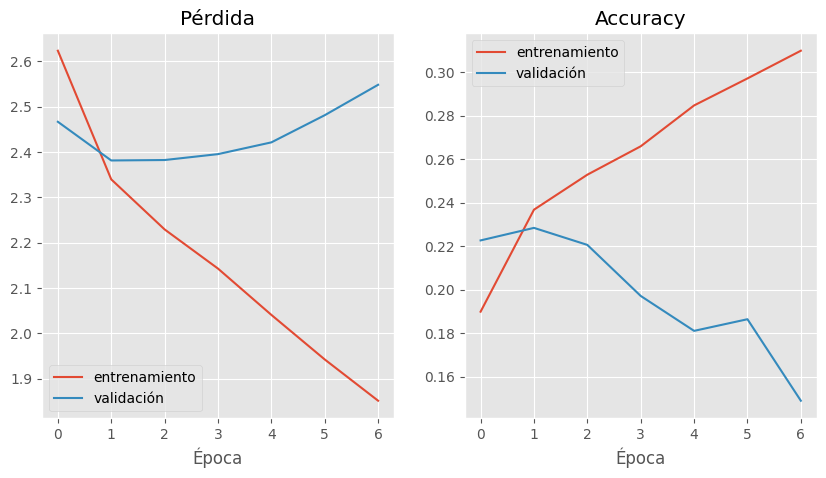

In [160]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(hist.history["loss"], label="entrenamiento")
plt.plot(hist.history["val_loss"], label="validación")
plt.title("Pérdida"); plt.xlabel("Época"); plt.legend()
plt.subplot(122)
plt.plot(hist.history["accuracy"], label="entrenamiento")
plt.plot(hist.history["val_accuracy"], label="validación")
plt.title("Accuracy"); plt.xlabel("Época"); plt.legend()

In [154]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, cnn.predict(X_test), average="macro",multi_class='ovr')

102/102 [==============================] - 0s 2ms/step


0.7731364027114418

In [173]:
from sklearn.metrics import classification_report
predictions = cnn.predict(X_test)
y=[np.argmax(y_test[i]) for i in range(len(y_test))]
pred=[np.argmax(predictions[i]) for i in range(len(predictions))]
print(classification_report(y,pred))

102/102 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.19      0.09      0.12       195
           1       0.20      0.16      0.18       154
           2       0.00      0.00      0.00        39
           3       0.00      0.00      0.00        56
           4       0.22      0.39      0.28       457
           5       0.22      0.22      0.22       217
           6       0.27      0.24      0.25        63
           7       0.24      0.48      0.32       595
           8       0.15      0.09      0.11       102
           9       0.18      0.03      0.05       106
          10       0.00      0.00      0.00        25
          11       0.00      0.00      0.00        41
          12       0.22      0.20      0.21       143
          13       0.00      0.00      0.00        51
          14       0.00      0.00      0.00        41
          15       0.00      0.00      0.00       114
          16       0.24   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


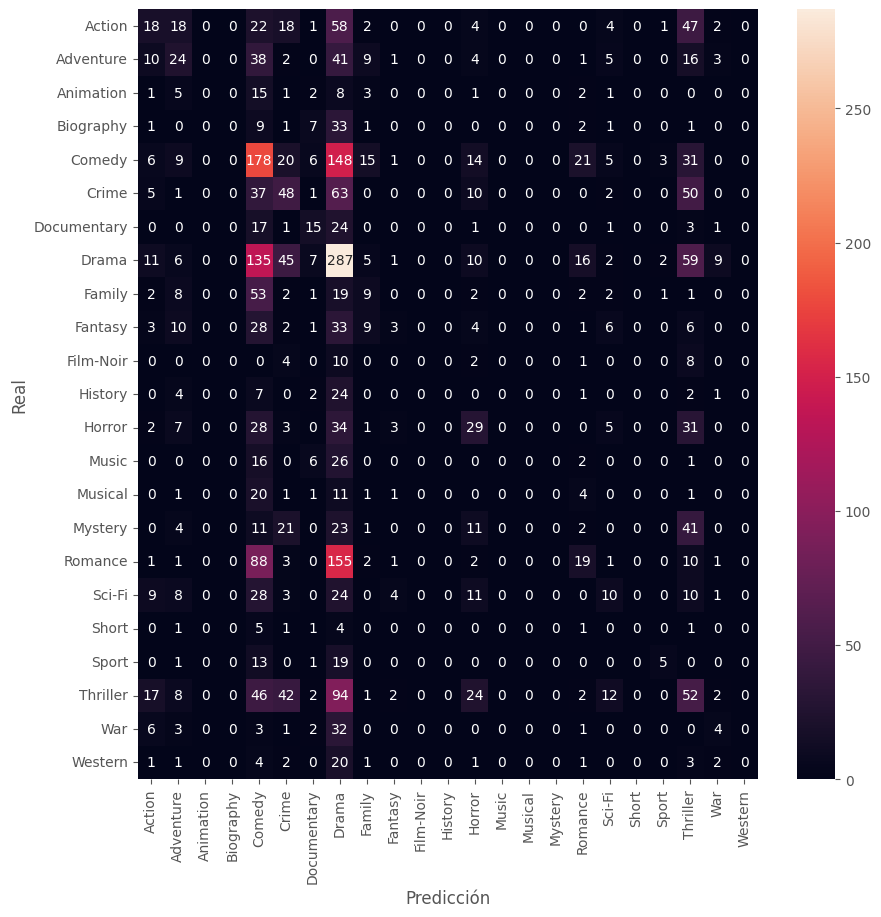

In [174]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, pred)
cm = pd.DataFrame(data=cm, columns=gen, index=gen)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.show()